In [7]:
from finders.data_finders import find_csv_dir_files_ptb_xl
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import logging
from datetime import datetime

warnings.filterwarnings("ignore")

# Настройка логирования
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")

# Настройка стиля графиков
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = [14, 8]
plt.rcParams["figure.dpi"] = 100

In [11]:
def get_ptbxl_paths():
    """
    Получает пути к PTB-XL данным
    """
    print("=" * 70)
    print("ПОЛУЧЕНИЕ ПУТЕЙ К ДАННЫМ PTB-XL")
    print("=" * 70)

    try:
        # Получаем корневую директорию проекта
        current_dir = Path.cwd()

        # Ищем корень проекта
        project_root = None
        for parent in [current_dir] + list(current_dir.parents):
            if (parent / "data").exists() and (parent / "plots").exists():
                project_root = parent
                break

        if project_root is None:
            project_root = current_dir
            print(
                f"⚠ Корень проекта не найден, используем текущую директорию: {project_root}"
            )
        else:
            print(f"✓ Корень проекта найден: {project_root}")

        # Получаем пути
        records100_dir, records500_dir, metadata_file, code_file = (
            find_csv_dir_files_ptb_xl(project_root)
        )

        print(f"✓ Директория записей 100 Гц: {records100_dir}")
        print(f"✓ Директория записей 500 Гц: {records500_dir}")
        print(f"✓ Файл метаданных: {metadata_file}")
        print(f"✓ Файл кодов: {code_file}")

        return records100_dir, records500_dir, metadata_file, code_file

    except FileNotFoundError as e:
        print(f"❌ Ошибка: {e}")
        exit()
    except Exception as e:
        print(f"❌ Произошла ошибка при получении путей: {e}")
        import traceback

        traceback.print_exc()
        exit()


def parse_scp_codes(scp_codes_str):
    """
    Парсит строку с SCP кодами из формата JSON

    Пример: '{"NORM": 100, "ABN": 50, "MI": 30}'
    """
    if pd.isna(scp_codes_str):
        return {}

    try:
        # Преобразуем строку в словарь
        import json

        codes_dict = json.loads(scp_codes_str.replace("'", '"'))
        return codes_dict
    except:
        # Если не JSON, пытаемся разобрать вручную
        codes_dict = {}
        try:
            # Убираем фигурные скобки и разделяем
            clean_str = scp_codes_str.strip("{}").replace("'", "").replace('"', "")
            pairs = clean_str.split(",")
            for pair in pairs:
                if ":" in pair:
                    key, value = pair.split(":", 1)
                    codes_dict[key.strip()] = float(value.strip())
        except:
            pass
        return codes_dict


def create_scp_to_aha_mapping(code_mapping_df):
    """
    Создает словарь для сопоставления SCP кодов с AHA кодами
    """
    scp_to_aha = {}

    # Проверяем наличие нужных столбцов
    if "AHA code" not in code_mapping_df.columns:
        print("⚠ В таблице кодов нет столбца 'AHA code'")
        return scp_to_aha

    # Первый столбец содержит SCP коды
    scp_code_col = code_mapping_df.columns[0]

    for idx, row in code_mapping_df.iterrows():
        scp_code = str(row[scp_code_col]).strip()
        aha_code = row["AHA code"]

        # Проверяем, есть ли AHA код
        if pd.notna(aha_code) and aha_code != "":
            # Преобразуем в строку и очищаем
            aha_str = str(aha_code).strip()

            # Может быть несколько кодов через запятую
            if "," in aha_str:
                aha_codes = [c.strip() for c in aha_str.split(",")]
            else:
                aha_codes = [aha_str]

            # Добавляем в словарь
            scp_to_aha[scp_code] = aha_codes

    print(f"✓ Создано сопоставление для {len(scp_to_aha)} SCP кодов с AHA кодами")

    # Показываем примеры
    print("  Примеры сопоставлений:")
    for i, (scp, aha_list) in enumerate(list(scp_to_aha.items())[:5]):
        print(f"    {scp} -> {', '.join(aha_list)}")

    return scp_to_aha


def extract_aha_codes_for_record(scp_codes_dict, scp_to_aha_mapping):
    """
    Извлекает AHA коды для конкретной записи на основе SCP кодов
    """
    aha_codes = []

    if not scp_codes_dict:
        return aha_codes

    for scp_code in scp_codes_dict.keys():
        # Проверяем, есть ли этот SCP код в нашем сопоставлении
        if scp_code in scp_to_aha_mapping:
            aha_codes.extend(scp_to_aha_mapping[scp_code])

    # Удаляем дубликаты и возвращаем
    return list(set(aha_codes))


def correct_age_values(df):
    """
    Корректирует значения возраста:
    - Если возраст >= 200, ищем оригинальную запись этого пациента
    - Используем первый корректный возраст для пациента
    """
    print("\n" + "=" * 60)
    print("КОРРЕКЦИЯ ВОЗРАСТА")
    print("=" * 60)

    # Создаем копию для работы
    df_corrected = df.copy()

    # Ищем записи с некорректным возрастом (>= 200)
    incorrect_age_mask = df_corrected["age"] >= 200
    incorrect_count = incorrect_age_mask.sum()

    if incorrect_count == 0:
        print("✓ Нет записей с некорректным возрастом (>= 200)")
        return df_corrected

    print(f"⚠ Найдено {incorrect_count} записей с некорректным возрастом (>= 200)")
    print("  Исходное распределение возраста:")
    print(f"    • Минимальный: {df_corrected['age'].min():.1f}")
    print(f"    • Максимальный: {df_corrected['age'].max():.1f}")
    print(f"    • Средний: {df_corrected['age'].mean():.1f}")

    # Стратегия: для пациентов с некорректным возрастом используем медианный возраст
    # всех других записей этого пациента с корректным возрастом
    corrected_count = 0

    for patient_id in df_corrected.loc[incorrect_age_mask, "patient_id"].unique():
        # Находим все записи этого пациента
        patient_mask = df_corrected["patient_id"] == patient_id

        # Находим корректные возрасты у этого пациента
        valid_ages = df_corrected.loc[patient_mask & ~incorrect_age_mask, "age"]

        if len(valid_ages) > 0:
            # Используем медианный возраст из корректных записей
            corrected_age = valid_ages.median()

            # Заменяем некорректные возрасты у этого пациента
            df_corrected.loc[patient_mask & incorrect_age_mask, "age"] = corrected_age
            corrected_count += (patient_mask & incorrect_age_mask).sum()
        else:
            # Если нет корректных записей у этого пациента, используем глобальную медиану
            global_median = df_corrected.loc[~incorrect_age_mask, "age"].median()
            df_corrected.loc[patient_mask & incorrect_age_mask, "age"] = global_median
            corrected_count += (patient_mask & incorrect_age_mask).sum()

    print(f"✓ Исправлено {corrected_count} записей с некорректным возрастом")
    print("  Исправленное распределение возраста:")
    print(f"    • Минимальный: {df_corrected['age'].min():.1f}")
    print(f"    • Максимальный: {df_corrected['age'].max():.1f}")
    print(f"    • Средний: {df_corrected['age'].mean():.1f}")

    # Статистика по исправлениям
    if corrected_count > 0:
        print("\n  СТАТИСТИКА ИСПРАВЛЕНИЙ:")
        age_groups = {
            "300-399": ((df["age"] >= 300) & (df["age"] < 400)).sum(),
            "200-299": ((df["age"] >= 200) & (df["age"] < 300)).sum(),
        }

        for group, count in age_groups.items():
            if count > 0:
                print(f"    • Возраст {group}: {count} записей")

    return df_corrected


def analyze_basic_statistics(df, code_mapping_df):
    """
    Базовый анализ датасета
    """
    print("\n" + "=" * 70)
    print("БАЗОВЫЙ АНАЛИЗ ДАТАСЕТА PTB-XL")
    print("=" * 70)

    print(f"Всего записей в датасете: {len(df):,}")
    print(f"Количество колонок: {len(df.columns)}")

    # Основная информация
    print("\n📊 ОСНОВНАЯ ИНФОРМАЦИЯ:")
    print("-" * 50)

    # Возраст
    age_stats = df["age"].describe()
    print("\nВОЗРАСТ ПАЦИЕНТОВ (ПОСЛЕ КОРРЕКЦИИ):")
    print(f"  • Средний: {age_stats['mean']:.1f} лет")
    print(f"  • Медиана: {age_stats['50%']:.1f} лет")
    print(f"  • Min: {age_stats['min']:.1f} лет")
    print(f"  • Max: {age_stats['max']:.1f} лет")
    print(f"  • Пропущено: {df['age'].isna().sum()} значений")

    # Пол
    gender_counts = df["sex"].value_counts()
    print("\nРАСПРЕДЕЛЕНИЕ ПО ПОЛУ:")
    for gender, count in gender_counts.items():
        percentage = count / len(df) * 100
        gender_name = (
            "Мужчины" if gender == 1 else "Женщины" if gender == 0 else f"Пол {gender}"
        )
        print(f"  • {gender_name}: {count:,} ({percentage:.1f}%)")

    # Высота и вес
    if "height" in df.columns:
        print("\nАНТРОПОМЕТРИЧЕСКИЕ ДАННЫЕ:")
        print(f"  • Рост (средний): {df['height'].mean():.1f} см")
        print(f"  • Вес (средний): {df['weight'].mean():.1f} кг")

    # Создаем сопоставление SCP -> AHA
    scp_to_aha_mapping = create_scp_to_aha_mapping(code_mapping_df)

    # Анализ SCP кодов
    print("\nАНАЛИЗ SCP КОДОВ:")
    print("-" * 50)

    all_scp_codes = []
    records_with_codes = 0
    all_aha_codes = []
    records_with_aha = 0

    # Для сохранения детальной информации
    detailed_scp_info = []
    detailed_aha_info = []

    for idx, row in df.iterrows():
        scp_codes = parse_scp_codes(row["scp_codes"])
        if scp_codes:
            records_with_codes += 1
            scp_code_list = list(scp_codes.keys())
            all_scp_codes.extend(scp_code_list)

            # Сохраняем детальную информацию по SCP
            for scp_code in scp_code_list:
                detailed_scp_info.append(
                    {
                        "ecg_id": row["ecg_id"],
                        "patient_id": row["patient_id"],
                        "scp_code": scp_code,
                        "confidence": scp_codes[scp_code],
                    }
                )

            # Извлекаем AHA коды для этой записи
            aha_codes = extract_aha_codes_for_record(scp_codes, scp_to_aha_mapping)
            if aha_codes:
                records_with_aha += 1
                all_aha_codes.extend(aha_codes)

                # Сохраняем детальную информацию по AHA
                for aha_code in aha_codes:
                    detailed_aha_info.append(
                        {
                            "ecg_id": row["ecg_id"],
                            "patient_id": row["patient_id"],
                            "aha_code": aha_code,
                        }
                    )

    scp_counter = Counter(all_scp_codes)
    aha_counter = Counter(all_aha_codes)

    print(
        f"  • Записей с SCP кодами: {records_with_codes} ({records_with_codes / len(df) * 100:.1f}%)"
    )
    print(f"  • Уникальных SCP кодов: {len(scp_counter)}")
    print(f"  • Всего присвоенных SCP кодов: {len(all_scp_codes)}")
    print(
        f"  • Среднее SCP кодов на запись: {len(all_scp_codes) / records_with_codes:.2f}"
        if records_with_codes > 0
        else "  • Нет записей с SCP кодами"
    )

    # Топ-10 SCP кодов
    print("\n  ТОП-10 САМЫХ ЧАСТЫХ SCP КОДОВ:")
    for i, (code, count) in enumerate(scp_counter.most_common(10), 1):
        # Ищем описание в таблице кодов
        description = "Неизвестно"
        match = code_mapping_df[code_mapping_df.iloc[:, 0] == code]
        if not match.empty and "description" in match.columns:
            desc = match.iloc[0]["description"]
            if pd.notna(desc):
                description = (
                    str(desc)[:50] + "..." if len(str(desc)) > 50 else str(desc)
                )

        print(f"    {i:2d}. {code:<10} - {count:>6,} записей - {description}")

    # Анализ AHA кодов
    print("\nАНАЛИЗ AHA КОДОВ:")
    print("-" * 50)

    print(
        f"  • Записей с AHA кодами: {records_with_aha} ({records_with_aha / len(df) * 100:.1f}%)"
    )
    print(f"  • Уникальных AHA кодов: {len(aha_counter)}")
    print(f"  • Всего присвоенных AHA кодов: {len(all_aha_codes)}")
    print(
        f"  • Среднее AHA кодов на запись с AHA: {len(all_aha_codes) / records_with_aha:.2f}"
        if records_with_aha > 0
        else "  • Нет записей с AHA кодами"
    )

    # Топ-10 AHA кодов
    if aha_counter:
        print("\n  ТОП-10 САМЫХ ЧАСТЫХ AHA КОДОВ:")
        for i, (code, count) in enumerate(aha_counter.most_common(10), 1):
            percentage = (
                count / len(all_aha_codes) * 100 if len(all_aha_codes) > 0 else 0
            )
            print(
                f"    {i:2d}. AHA {code:<5} - {count:>6,} записей ({percentage:.1f}%)"
            )
    else:
        print("\n  Нет записей с AHA кодами")

    # Создаем DataFrame для детальной информации
    detailed_scp_df = (
        pd.DataFrame(detailed_scp_info) if detailed_scp_info else pd.DataFrame()
    )
    detailed_aha_df = (
        pd.DataFrame(detailed_aha_info) if detailed_aha_info else pd.DataFrame()
    )

    return (
        scp_counter,
        aha_counter,
        scp_to_aha_mapping,
        detailed_scp_df,
        detailed_aha_df,
    )


def visualize_age_distribution(df):
    """
    Визуализация распределения по возрасту
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Гистограмма возраста
    axes[0].hist(
        df["age"].dropna(), bins=30, edgecolor="black", alpha=0.7, color="skyblue"
    )
    axes[0].set_xlabel("Возраст (лет)", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Количество пациентов", fontsize=12, fontweight="bold")
    axes[0].set_title(
        "Распределение пациентов по возрасту", fontsize=14, fontweight="bold"
    )
    axes[0].grid(True, alpha=0.3)

    # Boxplot возраста
    axes[1].boxplot(
        df["age"].dropna(),
        vert=False,
        patch_artist=True,
        boxprops=dict(facecolor="lightcoral"),
    )
    axes[1].set_xlabel("Возраст (лет)", fontsize=12, fontweight="bold")
    axes[1].set_title("Boxplot возраста", fontsize=14, fontweight="bold")
    axes[1].grid(True, alpha=0.3)

    # Возраст по полу
    gender_data = []
    gender_labels = []

    for gender in sorted(df["sex"].unique()):
        gender_name = (
            "Мужчины" if gender == 1 else "Женщины" if gender == 0 else f"Пол {gender}"
        )
        ages = df[df["sex"] == gender]["age"].dropna()
        if len(ages) > 0:
            gender_data.append(ages)
            gender_labels.append(gender_name)

    if gender_data:
        boxplot = axes[2].boxplot(gender_data, labels=gender_labels, patch_artist=True)
        for patch, color in zip(
            boxplot["boxes"], ["lightblue", "lightpink"][: len(gender_data)]
        ):
            patch.set_facecolor(color)
        axes[2].set_ylabel("Возраст (лет)", fontsize=12, fontweight="bold")
        axes[2].set_title(
            "Распределение возраста по полу", fontsize=14, fontweight="bold"
        )
        axes[2].grid(True, alpha=0.3)
        axes[2].tick_params(axis="x", rotation=45)

    plt.tight_layout()
    plt.show()


def visualize_gender_distribution(df):
    """
    Визуализация распределения по полу
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Столбчатая диаграмма
    gender_counts = df["sex"].value_counts().sort_index()
    gender_labels = []

    for gender in gender_counts.index:
        if gender == 1:
            gender_labels.append("Мужчины")
        elif gender == 0:
            gender_labels.append("Женщины")
        else:
            gender_labels.append(f"Пол {gender}")

    colors = ["lightpink", "lightblue"][: len(gender_counts)]
    bars = axes[0].bar(
        gender_labels, gender_counts.values, color=colors, edgecolor="black", width=0.6
    )
    axes[0].set_xlabel("Пол", fontsize=12, fontweight="bold")
    axes[0].set_ylabel("Количество пациентов", fontsize=12, fontweight="bold")
    axes[0].set_title("Распределение пациентов по полу", fontsize=14, fontweight="bold")
    axes[0].grid(True, alpha=0.3, axis="y")

    # Добавляем значения
    for bar in bars:
        height = bar.get_height()
        axes[0].text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{int(height):,}",
            ha="center",
            va="bottom",
            fontweight="bold",
        )

    # Круговая диаграмма
    wedges, texts, autotexts = axes[1].pie(
        gender_counts.values,
        labels=gender_labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=colors,
        explode=[0.05] * len(gender_counts),
    )
    axes[1].set_title("Доля пациентов по полу", fontsize=14, fontweight="bold")

    for autotext in autotexts:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    plt.tight_layout()
    plt.show()


def visualize_scp_codes_distribution(scp_counter, code_mapping_df):
    """
    Визуализация распределения SCP кодов
    """
    if not scp_counter:
        print("Нет данных о SCP кодах для визуализации")
        return

    # Берем топ-20 кодов
    top_scp = dict(scp_counter.most_common(20))

    fig, axes = plt.subplots(2, 2, figsize=(18, 12))

    # 1. Столбчатая диаграмма топ-20 SCP кодов
    codes = list(top_scp.keys())
    counts = list(top_scp.values())

    bars = axes[0, 0].bar(
        range(len(codes)),
        counts,
        color=plt.cm.tab20c(np.arange(len(codes)) / len(codes)),
        edgecolor="black",
    )

    axes[0, 0].set_xlabel("SCP код", fontsize=12, fontweight="bold")
    axes[0, 0].set_ylabel("Количество записей", fontsize=12, fontweight="bold")
    axes[0, 0].set_title(
        "Топ-20 самых частых SCP кодов", fontsize=14, fontweight="bold"
    )
    axes[0, 0].set_xticks(range(len(codes)))
    axes[0, 0].set_xticklabels(codes, rotation=45, fontsize=10)
    axes[0, 0].grid(True, alpha=0.3, axis="y")

    # 2. Круговая диаграмма (топ-10)
    top_10 = dict(scp_counter.most_common(10))
    if len(top_10) > 1:
        wedges, texts, autotexts = axes[0, 1].pie(
            top_10.values(),
            labels=top_10.keys(),
            autopct="%1.1f%%",
            startangle=90,
            colors=plt.cm.Set3(np.arange(len(top_10)) / len(top_10)),
        )
        axes[0, 1].set_title("Топ-10 SCP кодов (доли)", fontsize=14, fontweight="bold")

        for autotext in autotexts:
            autotext.set_color("white")
            autotext.set_fontweight("bold")

    # 3. Гистограмма распределения частот
    all_counts = list(scp_counter.values())
    axes[1, 0].hist(
        all_counts, bins=30, edgecolor="black", alpha=0.7, color="lightgreen", log=True
    )
    axes[1, 0].set_xlabel("Частота кода", fontsize=12, fontweight="bold")
    axes[1, 0].set_ylabel(
        "Количество кодов (лог шкала)", fontsize=12, fontweight="bold"
    )
    axes[1, 0].set_title(
        "Распределение частот всех SCP кодов", fontsize=14, fontweight="bold"
    )
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Кумулятивное распределение
    sorted_counts = sorted(scp_counter.values(), reverse=True)
    cumulative = np.cumsum(sorted_counts) / sum(sorted_counts) * 100

    axes[1, 1].plot(
        range(1, len(cumulative) + 1), cumulative, linewidth=2, color="darkblue"
    )
    axes[1, 1].fill_between(
        range(1, len(cumulative) + 1), cumulative, alpha=0.3, color="lightblue"
    )
    axes[1, 1].set_xlabel(
        "Количество самых частых кодов", fontsize=12, fontweight="bold"
    )
    axes[1, 1].set_ylabel("Процент покрытия (%)", fontsize=12, fontweight="bold")
    axes[1, 1].set_title(
        "Кумулятивное распределение SCP кодов", fontsize=14, fontweight="bold"
    )
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_xlim(0, 100)

    plt.suptitle(
        "АНАЛИЗ РАСПРЕДЕЛЕНИЯ SCP КОДОВ", fontsize=16, fontweight="bold", y=1.02
    )
    plt.tight_layout()
    plt.show()


def visualize_aha_codes_distribution(aha_counter):
    """
    Визуализация распределения AHA кодов
    """
    if not aha_counter:
        print("Нет данных о AHA кодах для визуализации")
        return

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))

    # 1. Столбчатая диаграмма топ-20 AHA кодов
    top_aha = dict(aha_counter.most_common(20))
    codes = list(top_aha.keys())
    counts = list(top_aha.values())

    bars = axes[0, 0].bar(
        range(len(codes)),
        counts,
        color=plt.cm.tab20(np.arange(len(codes)) / len(codes)),
        edgecolor="black",
    )

    axes[0, 0].set_xlabel("AHA код", fontsize=12, fontweight="bold")
    axes[0, 0].set_ylabel("Количество записей", fontsize=12, fontweight="bold")
    axes[0, 0].set_title(
        "Топ-20 самых частых AHA кодов", fontsize=14, fontweight="bold"
    )
    axes[0, 0].set_xticks(range(len(codes)))
    axes[0, 0].set_xticklabels(
        [f"AHA {code}" for code in codes], rotation=45, fontsize=10
    )
    axes[0, 0].grid(True, alpha=0.3, axis="y")

    # Добавляем значения
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        axes[0, 0].text(
            bar.get_x() + bar.get_width() / 2.0,
            height + 0.1,
            f"{int(count):,}",
            ha="center",
            va="bottom",
            fontsize=9,
        )

    # 2. Круговая диаграмма (топ-10)
    top_10 = dict(aha_counter.most_common(10))
    if len(top_10) > 1:
        wedges, texts, autotexts = axes[0, 1].pie(
            top_10.values(),
            labels=[f"AHA {k}" for k in top_10.keys()],
            autopct="%1.1f%%",
            startangle=90,
            colors=plt.cm.Set2(np.arange(len(top_10)) / len(top_10)),
        )
        axes[0, 1].set_title("Топ-10 AHA кодов (доли)", fontsize=14, fontweight="bold")

        for autotext in autotexts:
            autotext.set_color("white")
            autotext.set_fontweight("bold")

    # 3. Гистограмма распределения частот
    all_counts = list(aha_counter.values())
    axes[1, 0].hist(
        all_counts, bins=20, edgecolor="black", alpha=0.7, color="lightcoral"
    )
    axes[1, 0].set_xlabel("Частота кода", fontsize=12, fontweight="bold")
    axes[1, 0].set_ylabel("Количество кодов", fontsize=12, fontweight="bold")
    axes[1, 0].set_title(
        "Распределение частот AHA кодов", fontsize=14, fontweight="bold"
    )
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Статистическая информация
    axes[1, 1].axis("off")

    total_assignments = sum(aha_counter.values())

    stats_text = f"""СТАТИСТИКА AHA КОДОВ:

Всего уникальных кодов: {len(aha_counter)}
Всего присвоений кодов: {total_assignments:,}

САМЫЕ ЧАСТЫЕ КОДЫ:
"""

    for i, (code, count) in enumerate(aha_counter.most_common(5), 1):
        percentage = count / total_assignments * 100 if total_assignments > 0 else 0
        stats_text += f"{i}. AHA {code}: {count:,} ({percentage:.1f}%)\n"

    stats_text += "\nОБЩАЯ СТАТИСТИКА:\n"
    if all_counts:
        stats_text += f"• Средняя частота: {np.mean(all_counts):.1f}\n"
        stats_text += f"• Медианная частота: {np.median(all_counts):.1f}\n"
        stats_text += f"• Максимальная частота: {np.max(all_counts):,}\n"
        stats_text += f"• Минимальная частота: {np.min(all_counts):,}\n"

    axes[1, 1].text(
        0.1,
        0.95,
        stats_text,
        transform=axes[1, 1].transAxes,
        verticalalignment="top",
        fontsize=11,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
    )

    plt.suptitle(
        "АНАЛИЗ РАСПРЕДЕЛЕНИЯ AHA КОДОВ", fontsize=16, fontweight="bold", y=1.02
    )
    plt.tight_layout()
    plt.show()


def analyze_comparison_with_without_aha(df, scp_to_aha_mapping):
    """
    Анализ сравнения записей с AHA кодами и без них
    """
    print("\n" + "=" * 70)
    print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ: ЗАПИСИ С AHA КОДАМИ vs БЕЗ AHA КОДОВ")
    print("=" * 70)

    # Разделяем данные
    records_with_aha = []
    records_without_aha = []

    for idx, row in df.iterrows():
        scp_codes = parse_scp_codes(row["scp_codes"])
        if scp_codes:
            aha_codes = extract_aha_codes_for_record(scp_codes, scp_to_aha_mapping)
            if aha_codes:
                records_with_aha.append(idx)
            else:
                records_without_aha.append(idx)
        else:
            records_without_aha.append(idx)

    df_with_aha = df.loc[records_with_aha]
    df_without_aha = df.loc[records_without_aha]

    print("\nРАСПРЕДЕЛЕНИЕ:")
    print(f"  • Всего записей: {len(df):,}")
    print(
        f"  • С AHA кодами: {len(df_with_aha):,} ({len(df_with_aha) / len(df) * 100:.1f}%)"
    )
    print(
        f"  • Без AHA кодов: {len(df_without_aha):,} ({len(df_without_aha) / len(df) * 100:.1f}%)"
    )

    # Сравнение по возрасту
    print("\nСРАВНЕНИЕ ПО ВОЗРАСТУ:")
    print("  • С AHA кодами:")
    print(f"    - Средний: {df_with_aha['age'].mean():.1f} лет")
    print(f"    - Медиана: {df_with_aha['age'].median():.1f} лет")
    print(f"    - Стандартное отклонение: {df_with_aha['age'].std():.1f}")

    print("  • Без AHA кодов:")
    print(f"    - Средний: {df_without_aha['age'].mean():.1f} лет")
    print(f"    - Медиана: {df_without_aha['age'].median():.1f} лет")
    print(f"    - Стандартное отклонение: {df_without_aha['age'].std():.1f}")

    # Сравнение по полу
    print("\nСРАВНЕНИЕ ПО ПОЛУ:")

    print("  • С AHA кодами:")
    gender_counts_with = df_with_aha["sex"].value_counts()
    for gender, count in gender_counts_with.items():
        gender_name = (
            "Мужчины" if gender == 1 else "Женщины" if gender == 0 else f"Пол {gender}"
        )
        percentage = count / len(df_with_aha) * 100
        print(f"    - {gender_name}: {count:,} ({percentage:.1f}%)")

    print("  • Без AHA кодов:")
    gender_counts_without = df_without_aha["sex"].value_counts()
    for gender, count in gender_counts_without.items():
        gender_name = (
            "Мужчины" if gender == 1 else "Женщины" if gender == 0 else f"Пол {gender}"
        )
        percentage = count / len(df_without_aha) * 100
        print(f"    - {gender_name}: {count:,} ({percentage:.1f}%)")

    # Визуализация сравнения
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # 1. Возрастное распределение
    axes[0, 0].hist(
        df_with_aha["age"].dropna(),
        bins=20,
        alpha=0.7,
        color="blue",
        edgecolor="black",
        label="С AHA кодами",
    )
    axes[0, 0].hist(
        df_without_aha["age"].dropna(),
        bins=20,
        alpha=0.7,
        color="red",
        edgecolor="black",
        label="Без AHA кодов",
    )
    axes[0, 0].set_xlabel("Возраст (лет)", fontsize=12, fontweight="bold")
    axes[0, 0].set_ylabel("Количество пациентов", fontsize=12, fontweight="bold")
    axes[0, 0].set_title("Распределение по возрасту", fontsize=14, fontweight="bold")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Boxplot возраста
    age_data = [df_with_aha["age"].dropna(), df_without_aha["age"].dropna()]
    boxplot = axes[0, 1].boxplot(
        age_data, labels=["С AHA", "Без AHA"], patch_artist=True
    )
    colors = ["lightblue", "lightcoral"]
    for patch, color in zip(boxplot["boxes"], colors):
        patch.set_facecolor(color)
    axes[0, 1].set_ylabel("Возраст (лет)", fontsize=12, fontweight="bold")
    axes[0, 1].set_title("Boxplot возраста", fontsize=14, fontweight="bold")
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Распределение по полу (с AHA)
    gender_labels = []
    gender_values = []
    for gender in sorted(gender_counts_with.index):
        if gender == 1:
            gender_labels.append("Мужчины")
        elif gender == 0:
            gender_labels.append("Женщины")
        else:
            gender_labels.append(f"Пол {gender}")
        gender_values.append(gender_counts_with[gender])

    wedges1, texts1, autotexts1 = axes[0, 2].pie(
        gender_values,
        labels=gender_labels,
        autopct="%1.1f%%",
        startangle=90,
        colors=["lightblue", "lightpink"][: len(gender_values)],
    )
    axes[0, 2].set_title(
        "Распределение по полу (с AHA)", fontsize=14, fontweight="bold"
    )

    for autotext in autotexts1:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    # 4. Распределение по полу (без AHA)
    gender_labels2 = []
    gender_values2 = []
    for gender in sorted(gender_counts_without.index):
        if gender == 1:
            gender_labels2.append("Мужчины")
        elif gender == 0:
            gender_labels2.append("Женщины")
        else:
            gender_labels2.append(f"Пол {gender}")
        gender_values2.append(gender_counts_without[gender])

    wedges2, texts2, autotexts2 = axes[1, 0].pie(
        gender_values2,
        labels=gender_labels2,
        autopct="%1.1f%%",
        startangle=90,
        colors=["lightblue", "lightpink"][: len(gender_values2)],
    )
    axes[1, 0].set_title(
        "Распределение по полу (без AHA)", fontsize=14, fontweight="bold"
    )

    for autotext in autotexts2:
        autotext.set_color("white")
        autotext.set_fontweight("bold")

    # 5. Количество SCP кодов
    scp_counts_with = []
    for idx in records_with_aha:
        scp_codes = parse_scp_codes(df.loc[idx, "scp_codes"])
        scp_counts_with.append(len(scp_codes) if scp_codes else 0)

    scp_counts_without = []
    for idx in records_without_aha:
        scp_codes = parse_scp_codes(df.loc[idx, "scp_codes"])
        scp_counts_without.append(len(scp_codes) if scp_codes else 0)

    axes[1, 1].hist(
        scp_counts_with,
        bins=10,
        alpha=0.7,
        color="blue",
        edgecolor="black",
        label="С AHA кодами",
    )
    axes[1, 1].hist(
        scp_counts_without,
        bins=10,
        alpha=0.7,
        color="red",
        edgecolor="black",
        label="Без AHA кодов",
    )
    axes[1, 1].set_xlabel("Количество SCP кодов", fontsize=12, fontweight="bold")
    axes[1, 1].set_ylabel("Количество записей", fontsize=12, fontweight="bold")
    axes[1, 1].set_title(
        "Распределение по количеству SCP кодов", fontsize=14, fontweight="bold"
    )
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. Статистическая информация
    axes[1, 2].axis("off")

    stats_text = f"""СРАВНИТЕЛЬНАЯ СТАТИСТИКА:

С AHA КОДАМИ:
• Записей: {len(df_with_aha):,}
• Средний возраст: {df_with_aha["age"].mean():.1f} лет
• Доля мужчин: {(gender_counts_with.get(1, 0) / len(df_with_aha) * 100 if 1 in gender_counts_with else 0):.1f}%
• Среднее SCP кодов: {np.mean(scp_counts_with):.2f}

БЕЗ AHA КОДОВ:
• Записей: {len(df_without_aha):,}
• Средний возраст: {df_without_aha["age"].mean():.1f} лет
• Доля мужчин: {(gender_counts_without.get(1, 0) / len(df_without_aha) * 100 if 1 in gender_counts_without else 0):.1f}%
• Среднее SCP кодов: {np.mean(scp_counts_without):.2f}

РАЗЛИЧИЯ:
• Возраст: {abs(df_with_aha["age"].mean() - df_without_aha["age"].mean()):.1f} лет
• Размер выборки: {abs(len(df_with_aha) - len(df_without_aha)):,} записей"""

    axes[1, 2].text(
        0.1,
        0.95,
        stats_text,
        transform=axes[1, 2].transAxes,
        verticalalignment="top",
        fontsize=11,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
    )

    plt.suptitle(
        "СРАВНЕНИЕ ЗАПИСЕЙ С AHA КОДАМИ И БЕЗ НИХ",
        fontsize=16,
        fontweight="bold",
        y=1.02,
    )
    plt.tight_layout()
    plt.show()

    return df_with_aha, df_without_aha


def save_analysis_results(
    df,
    scp_counter,
    aha_counter,
    scp_to_aha_mapping,
    detailed_scp_df,
    detailed_aha_df,
    code_mapping_df,  # Добавил code_mapping_df
    output_dir="ptb_xl_analysis",
):
    """
    Сохраняет результаты анализа в TXT и CSV файлы
    """
    try:
        # Создаем папку для результатов
        current_dir = Path.cwd()
        project_root = None
        for parent in [current_dir] + list(current_dir.parents):
            if (parent / "data").exists() and (parent / "plots").exists():
                project_root = parent
                break

        if project_root is None:
            project_root = current_dir

        output_path = project_root / "analysis_results" / "ptb_xl"
        output_path.mkdir(exist_ok=True, parents=True)

        print(f"\n💾 СОХРАНЕНИЕ РЕЗУЛЬТАТОВ В: {output_path.absolute()}")

        # 1. Сохраняем сводный отчет в TXT
        print("  1. Сохранение сводного отчета...")

        with open(output_path / "summary_report.txt", "w", encoding="utf-8") as f:
            f.write("=" * 80 + "\n")
            f.write("СВОДНЫЙ ОТЧЕТ ПО АНАЛИЗУ ДАТАСЕТА PTB-XL\n")
            f.write("=" * 80 + "\n\n")
            f.write(f"Дата анализа: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")

            # Общая статистика
            f.write("ОБЩАЯ СТАТИСТИКА:\n")
            f.write("-" * 80 + "\n")
            f.write(f"Всего записей (ECG): {len(df):,}\n")
            f.write(f"Уникальных пациентов: {df['patient_id'].nunique():,}\n\n")

            # Демографическая статистика
            f.write("ДЕМОГРАФИЧЕСКАЯ СТАТИСТИКА:\n")
            f.write("-" * 80 + "\n")
            f.write(f"Средний возраст: {df['age'].mean():.1f} лет\n")
            f.write(f"Медианный возраст: {df['age'].median():.1f} лет\n")
            f.write(f"Минимальный возраст: {df['age'].min():.1f} лет\n")
            f.write(f"Максимальный возраст: {df['age'].max():.1f} лет\n")

            gender_counts = df["sex"].value_counts()
            male_count = gender_counts.get(1, 0)
            female_count = gender_counts.get(0, 0)
            f.write(f"Мужчины: {male_count:,} ({male_count / len(df) * 100:.1f}%)\n")
            f.write(
                f"Женщины: {female_count:,} ({female_count / len(df) * 100:.1f}%)\n\n"
            )

            # Статистика SCP кодов
            f.write("СТАТИСТИКА SCP КОДОВ:\n")
            f.write("-" * 80 + "\n")
            records_with_scp = df["scp_codes"].notna().sum()
            f.write(
                f"Записей с SCP кодами: {records_with_scp:,} ({records_with_scp / len(df) * 100:.1f}%)\n"
            )
            f.write(f"Уникальных SCP кодов: {len(scp_counter)}\n")
            f.write(f"Всего присвоений SCP кодов: {sum(scp_counter.values()):,}\n")

            if records_with_scp > 0:
                f.write(
                    f"Среднее SCP кодов на запись: {sum(scp_counter.values()) / records_with_scp:.2f}\n"
                )

            f.write("\nТОП-20 САМЫХ ЧАСТЫХ SCP КОДОВ:\n")
            f.write("-" * 80 + "\n")
            f.write(
                f"{'№':<3} {'SCP код':<10} {'Количество':<12} {'Доля':<8} {'Накоп. доля':<12}\n"
            )
            f.write("-" * 80 + "\n")

            total_scp = sum(scp_counter.values())
            cumulative = 0
            for i, (code, count) in enumerate(scp_counter.most_common(20), 1):
                percentage = count / total_scp * 100
                cumulative += percentage
                f.write(
                    f"{i:<3} {code:<10} {count:<12,} {percentage:>6.1f}% {cumulative:>11.1f}%\n"
                )

            # Статистика AHA кодов
            f.write("\n\nСТАТИСТИКА AHA КОДОВ:\n")
            f.write("-" * 80 + "\n")

            # Подсчитываем записи с AHA кодами
            records_with_aha = 0
            total_aha_assignments = 0

            for idx, row in df.iterrows():
                scp_codes = parse_scp_codes(row["scp_codes"])
                if scp_codes:
                    aha_codes = extract_aha_codes_for_record(
                        scp_codes, scp_to_aha_mapping
                    )
                    if aha_codes:
                        records_with_aha += 1
                        total_aha_assignments += len(aha_codes)

            f.write(
                f"Записей с AHA кодами: {records_with_aha:,} ({records_with_aha / len(df) * 100:.1f}%)\n"
            )
            f.write(f"Уникальных AHA кодов: {len(aha_counter)}\n")
            f.write(f"Всего присвоений AHA кодов: {total_aha_assignments:,}\n")

            if records_with_aha > 0:
                f.write(
                    f"Среднее AHA кодов на запись с AHA: {total_aha_assignments / records_with_aha:.2f}\n"
                )

            if aha_counter:
                f.write("\nТОП-20 САМЫХ ЧАСТЫХ AHA КОДОВ:\n")
                f.write("-" * 80 + "\n")
                f.write(
                    f"{'№':<3} {'AHA код':<10} {'Количество':<12} {'Доля':<8} {'Накоп. доля':<12}\n"
                )
                f.write("-" * 80 + "\n")

                total_aha = sum(aha_counter.values())
                cumulative_aha = 0
                for i, (code, count) in enumerate(aha_counter.most_common(20), 1):
                    percentage = count / total_aha * 100
                    cumulative_aha += percentage
                    f.write(
                        f"{i:<3} AHA {code:<7} {count:<12,} {percentage:>6.1f}% {cumulative_aha:>11.1f}%\n"
                    )

            # Сопоставления
            f.write("\n\nСОПОСТАВЛЕНИЯ SCP -> AHA:\n")
            f.write("-" * 80 + "\n")
            f.write(f"Всего SCP кодов в таблице: {len(code_mapping_df)}\n")
            f.write(f"SCP кодов с сопоставлением AHA: {len(scp_to_aha_mapping)}\n")
            f.write(
                f"Процент SCP кодов с AHA: {len(scp_to_aha_mapping) / len(code_mapping_df) * 100:.1f}%\n"
            )

            # Примеры сопоставлений
            f.write("\nПримеры сопоставлений SCP -> AHA:\n")
            for i, (scp, aha_list) in enumerate(
                list(scp_to_aha_mapping.items())[:10], 1
            ):
                f.write(f"{i:2d}. {scp} -> {', '.join(aha_list)}\n")

        # 2. Сохраняем детальную статистику SCP кодов в CSV
        print("  2. Сохранение детальной статистики SCP кодов...")

        scp_stats = []
        for code, count in scp_counter.most_common():
            scp_stats.append(
                {
                    "scp_code": code,
                    "count": count,
                    "percentage": count / len(df) * 100,
                    "cumulative_percentage": 0,  # Будет рассчитано ниже
                }
            )

        # Рассчитываем кумулятивный процент
        total_scp_all = sum(scp_counter.values())
        cumulative = 0
        for i in range(len(scp_stats)):
            scp_stats[i]["cumulative_percentage"] = (
                cumulative + scp_stats[i]["percentage"]
            )
            cumulative += scp_stats[i]["percentage"]

        scp_df = pd.DataFrame(scp_stats)
        scp_df.to_csv(
            output_path / "scp_codes_detailed_statistics.csv",
            index=False,
            encoding="utf-8",
        )

        # 3. Сохраняем детальную статистику AHA кодов в CSV
        print("  3. Сохранение детальной статистики AHA кодов...")

        if aha_counter:
            aha_stats = []
            total_aha_all = sum(aha_counter.values())
            cumulative_aha = 0

            for code, count in aha_counter.most_common():
                percentage = count / total_aha_all * 100 if total_aha_all > 0 else 0
                aha_stats.append(
                    {
                        "aha_code": code,
                        "count": count,
                        "percentage": percentage,
                        "cumulative_percentage": cumulative_aha + percentage,
                    }
                )
                cumulative_aha += percentage

            aha_df = pd.DataFrame(aha_stats)
            aha_df.to_csv(
                output_path / "aha_codes_detailed_statistics.csv",
                index=False,
                encoding="utf-8",
            )

        # 4. Сохраняем сопоставление SCP -> AHA в CSV
        print("  4. Сохранение сопоставления SCP -> AHA...")

        mapping_data = []
        for scp_code, aha_codes in scp_to_aha_mapping.items():
            mapping_data.append(
                {
                    "scp_code": scp_code,
                    "aha_codes": ", ".join(aha_codes),
                    "num_aha_codes": len(aha_codes),
                }
            )

        mapping_df = pd.DataFrame(mapping_data)
        mapping_df.to_csv(
            output_path / "scp_to_aha_mapping.csv", index=False, encoding="utf-8"
        )

        # 5. Сохраняем детальные данные по записям с SCP кодами
        print("  5. Сохранение детальных данных по SCP кодам записей...")

        if not detailed_scp_df.empty:
            detailed_scp_df.to_csv(
                output_path / "records_scp_codes_detailed.csv",
                index=False,
                encoding="utf-8",
            )

        # 6. Сохраняем детальные данные по записям с AHA кодами
        print("  6. Сохранение детальных данных по AHA кодам записей...")

        if not detailed_aha_df.empty:
            detailed_aha_df.to_csv(
                output_path / "records_aha_codes_detailed.csv",
                index=False,
                encoding="utf-8",
            )

        # 7. Сохраняем исправленные данные пациентов
        print("  7. Сохранение исправленные данные пациентов...")

        # Сохраняем только основные колонки
        patient_cols = [
            "ecg_id",
            "patient_id",
            "age",
            "sex",
            "height",
            "weight",
            "scp_codes",
            "filename_lr",
            "filename_hr",
        ]
        patient_cols = [col for col in patient_cols if col in df.columns]

        patient_df = df[patient_cols].copy()
        patient_df.to_csv(
            output_path / "patients_corrected_data.csv", index=False, encoding="utf-8"
        )

        print(f"\n✅ Все результаты успешно сохранены в: {output_path}")
        print("   • summary_report.txt - сводный отчет")
        print("   • scp_codes_detailed_statistics.csv - детальная статистика SCP кодов")
        print("   • aha_codes_detailed_statistics.csv - детальная статистика AHA кодов")
        print("   • scp_to_aha_mapping.csv - сопоставление SCP -> AHA")
        print(
            "   • records_scp_codes_detailed.csv - детальные данные по SCP кодам записей"
        )
        print(
            "   • records_aha_codes_detailed.csv - детальные данные по AHA кодам записей"
        )
        print("   • patients_corrected_data.csv - исправленные данные пациентов")

    except Exception as e:
        print(f"⚠ Ошибка при сохранении результатов: {e}")
        import traceback

        traceback.print_exc()


def main():
    """
    Основная функция анализа PTB-XL датасета
    """
    print("=" * 80)
    print("АНАЛИЗ ДАТАСЕТА PTB-XL")
    print("=" * 80)

    # Получаем пути к данным
    records100_dir, records500_dir, metadata_file, code_file = get_ptbxl_paths()

    # Загружаем данные
    print("\n📂 Загрузка данных...")

    # Метаданные пациентов
    print(f"  Загрузка метаданных: {metadata_file.name}")
    df = pd.read_csv(metadata_file)
    print(f"    ✓ Загружено {len(df):,} записей")

    # Таблица кодов
    print(f"  Загрузка таблицы кодов: {code_file.name}")
    code_mapping_df = pd.read_csv(code_file)
    print(f"    ✓ Загружено {len(code_mapping_df)} строк кодов")

    # Проверяем наличие столбцов AHA
    if "AHA code" in code_mapping_df.columns:
        aha_count = code_mapping_df["AHA code"].notna().sum()
        print(
            f"    ✓ Найдены AHA коды: {aha_count} строк ({aha_count / len(code_mapping_df) * 100:.1f}% всех SCP кодов)"
        )
    else:
        print("    ⚠ Столбец 'AHA code' не найден")

    # Корректировка возраста
    df_corrected = correct_age_values(df)

    # Базовый анализ
    scp_counter, aha_counter, scp_to_aha_mapping, detailed_scp_df, detailed_aha_df = (
        analyze_basic_statistics(df_corrected, code_mapping_df)
    )

    # Визуализации
    print("\n📊 ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ...")
    print("-" * 50)

    print("  1. Визуализация распределения по возрасту...")
    visualize_age_distribution(df_corrected)

    print("  2. Визуализация распределения по полу...")
    visualize_gender_distribution(df_corrected)

    print("  3. Визуализация распределения SCP кодов...")
    visualize_scp_codes_distribution(scp_counter, code_mapping_df)

    if aha_counter:
        print("  4. Визуализация распределения AHA кодов...")
        visualize_aha_codes_distribution(aha_counter)
    else:
        print("  4. Пропуск визуализации AHA кодов (нет данных)")

    # Сравнительный анализ
    print("  5. Сравнительный анализ записей с AHA кодами и без них...")
    df_with_aha, df_without_aha = analyze_comparison_with_without_aha(
        df_corrected, scp_to_aha_mapping
    )

    # Сохранение результатов
    # Сохранение результатов
    save_analysis_results(
        df_corrected,
        scp_counter,
        aha_counter,
        scp_to_aha_mapping,
        detailed_scp_df,
        detailed_aha_df,
        code_mapping_df,
    )  # Добавил code_mapping_df

    print("\n" + "=" * 80)
    print("АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!")
    print("=" * 80)

    # Финальная сводка
    print("\n📋 ИТОГОВАЯ СВОДКА:")
    print(f"  • Всего записей: {len(df):,}")
    print(f"  • Уникальных пациентов: {df['patient_id'].nunique():,}")
    print(f"  • Уникальных SCP кодов: {len(scp_counter)}")
    print(f"  • Уникальных AHA кодов: {len(aha_counter)}")
    print(
        f"  • Записей с AHA кодами: {len(df_with_aha):,} ({len(df_with_aha) / len(df) * 100:.1f}%)"
    )

INFO: Found low resolution records: d:\deep_ecg_2026\data\ptb_xl\records100
INFO: Found high resolution records: d:\deep_ecg_2026\data\ptb_xl\records500
INFO: Successfully validated all paths for ptb_xl dataset


АНАЛИЗ ДАТАСЕТА PTB-XL
ПОЛУЧЕНИЕ ПУТЕЙ К ДАННЫМ PTB-XL
✓ Корень проекта найден: d:\deep_ecg_2026
✓ Директория записей 100 Гц: d:\deep_ecg_2026\data\ptb_xl\records100
✓ Директория записей 500 Гц: d:\deep_ecg_2026\data\ptb_xl\records500
✓ Файл метаданных: d:\deep_ecg_2026\data\ptb_xl\ptbxl_database.csv
✓ Файл кодов: d:\deep_ecg_2026\data\ptb_xl\scp_statements.csv

📂 Загрузка данных...
  Загрузка метаданных: ptbxl_database.csv
    ✓ Загружено 21,799 записей
  Загрузка таблицы кодов: scp_statements.csv
    ✓ Загружено 71 строк кодов
    ✓ Найдены AHA коды: 37 строк (52.1% всех SCP кодов)

КОРРЕКЦИЯ ВОЗРАСТА
⚠ Найдено 293 записей с некорректным возрастом (>= 200)
  Исходное распределение возраста:
    • Минимальный: 2.0
    • Максимальный: 300.0
    • Средний: 62.8
✓ Исправлено 293 записей с некорректным возрастом
  Исправленное распределение возраста:
    • Минимальный: 2.0
    • Максимальный: 89.0
    • Средний: 59.6

  СТАТИСТИКА ИСПРАВЛЕНИЙ:
    • Возраст 300-399: 293 записей

БАЗОВЫЙ А

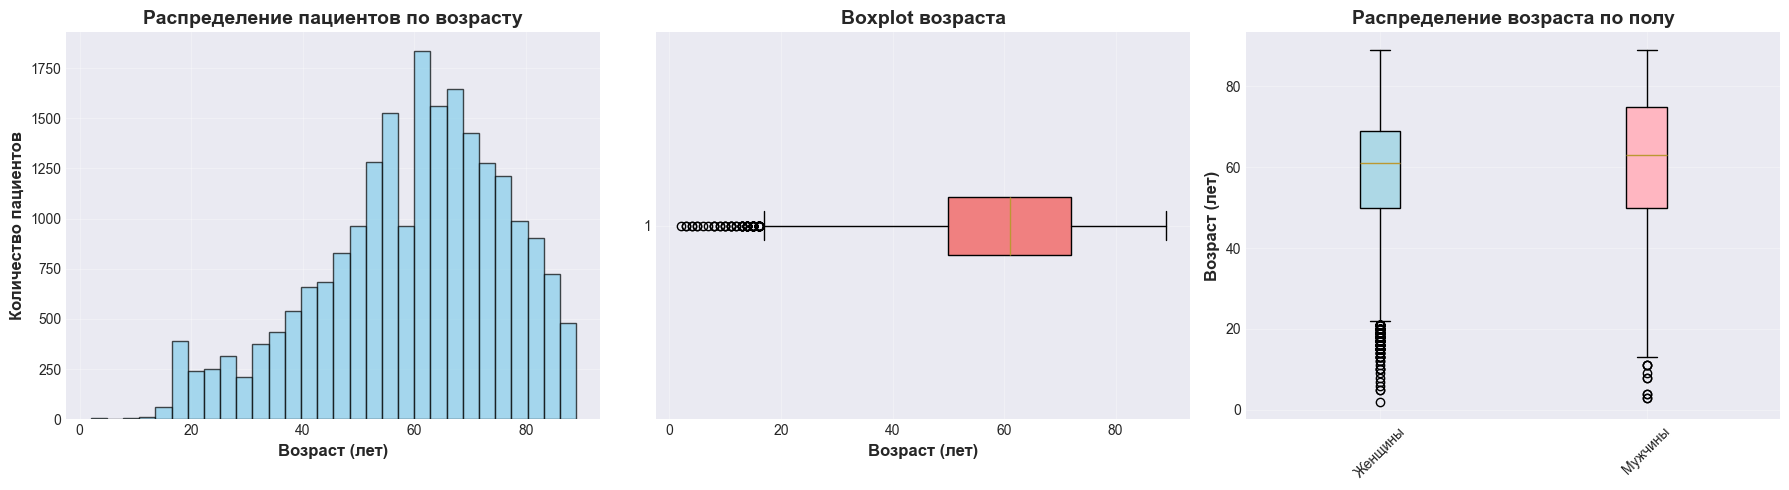

  2. Визуализация распределения по полу...


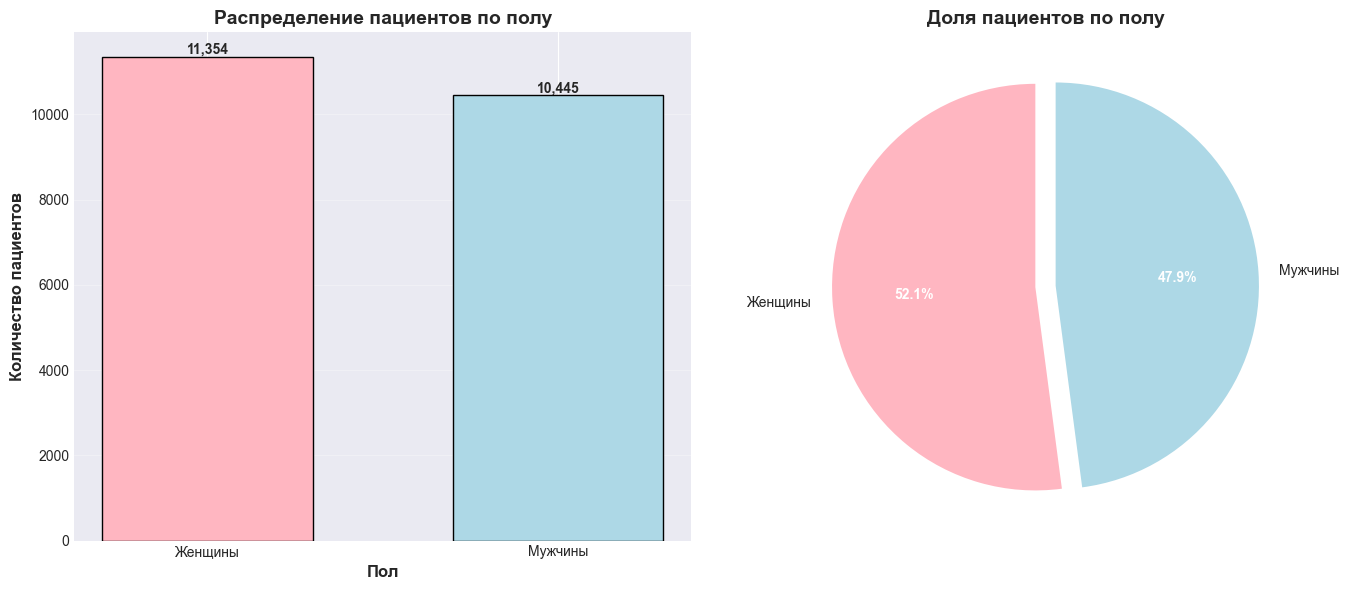

  3. Визуализация распределения SCP кодов...


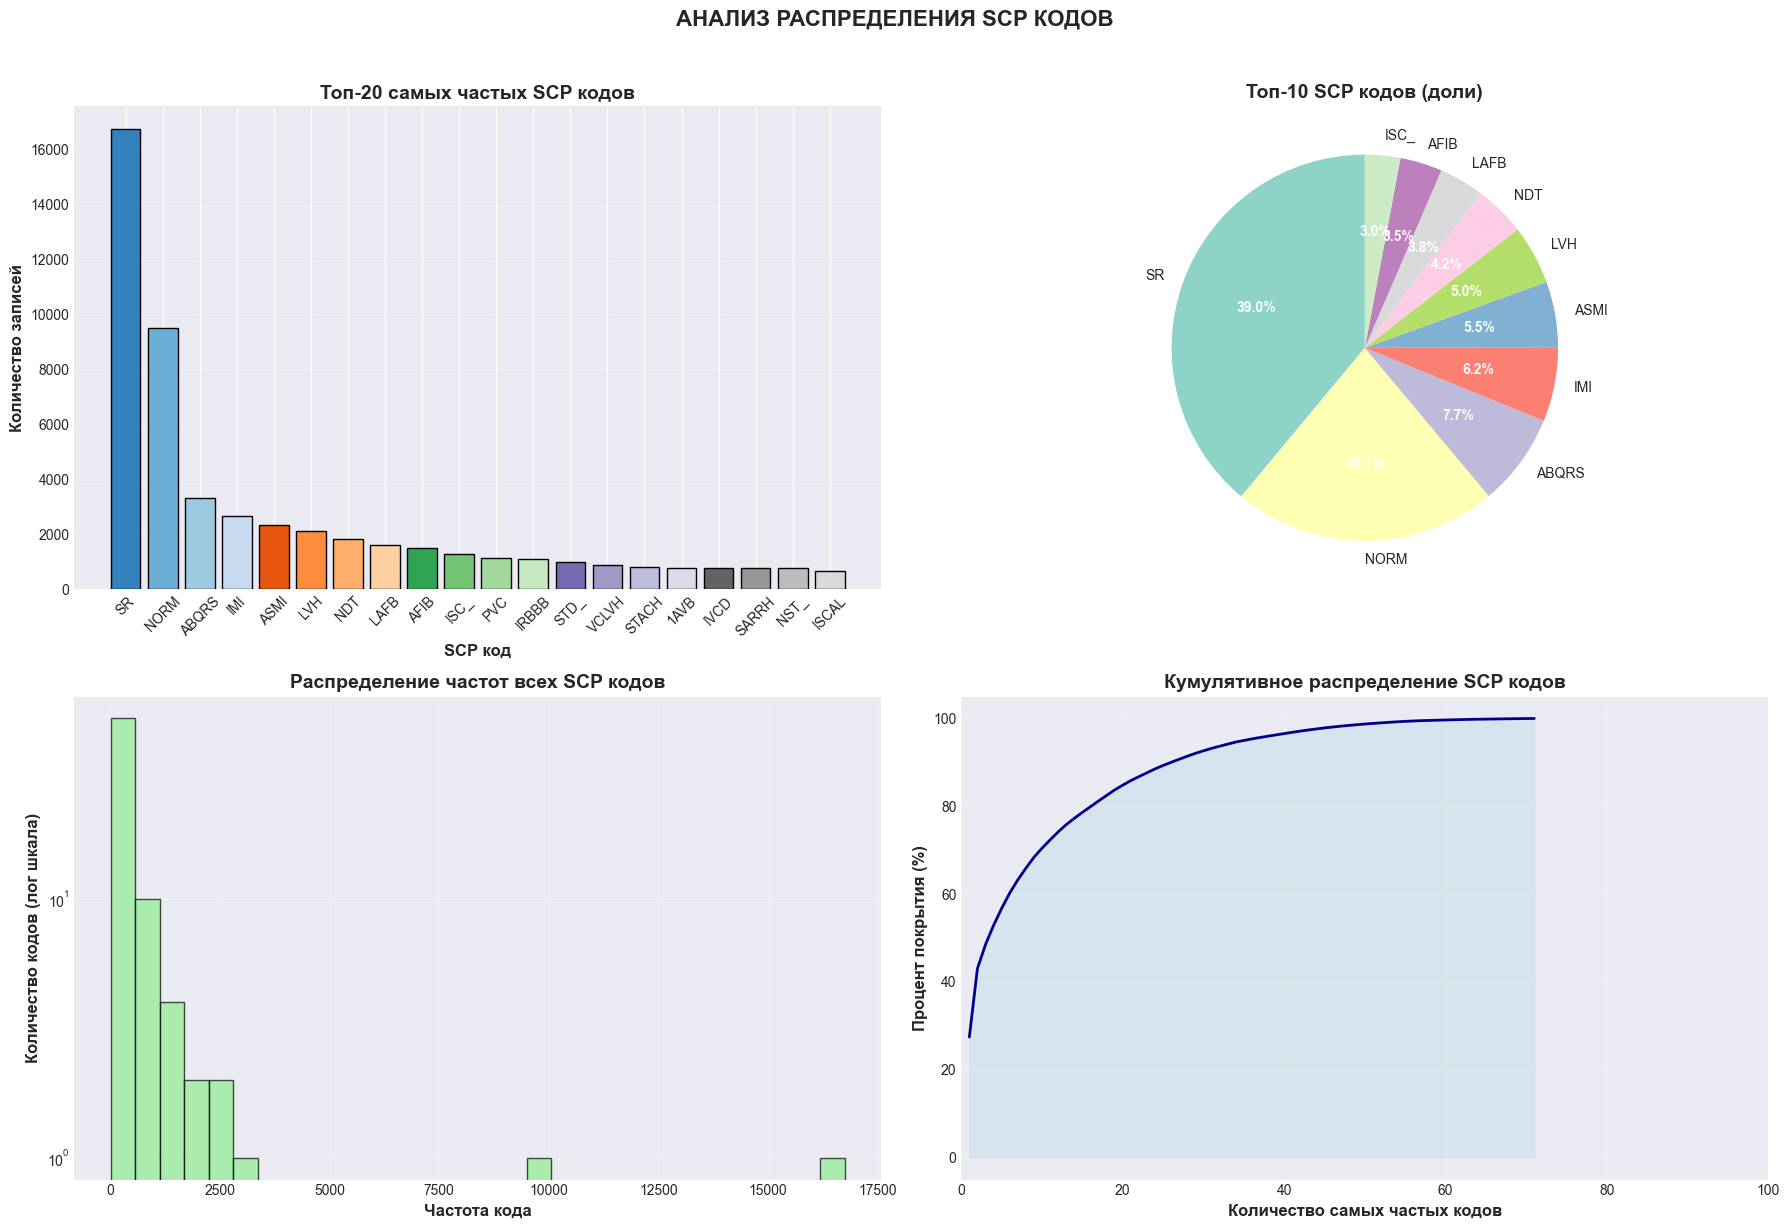

  4. Визуализация распределения AHA кодов...


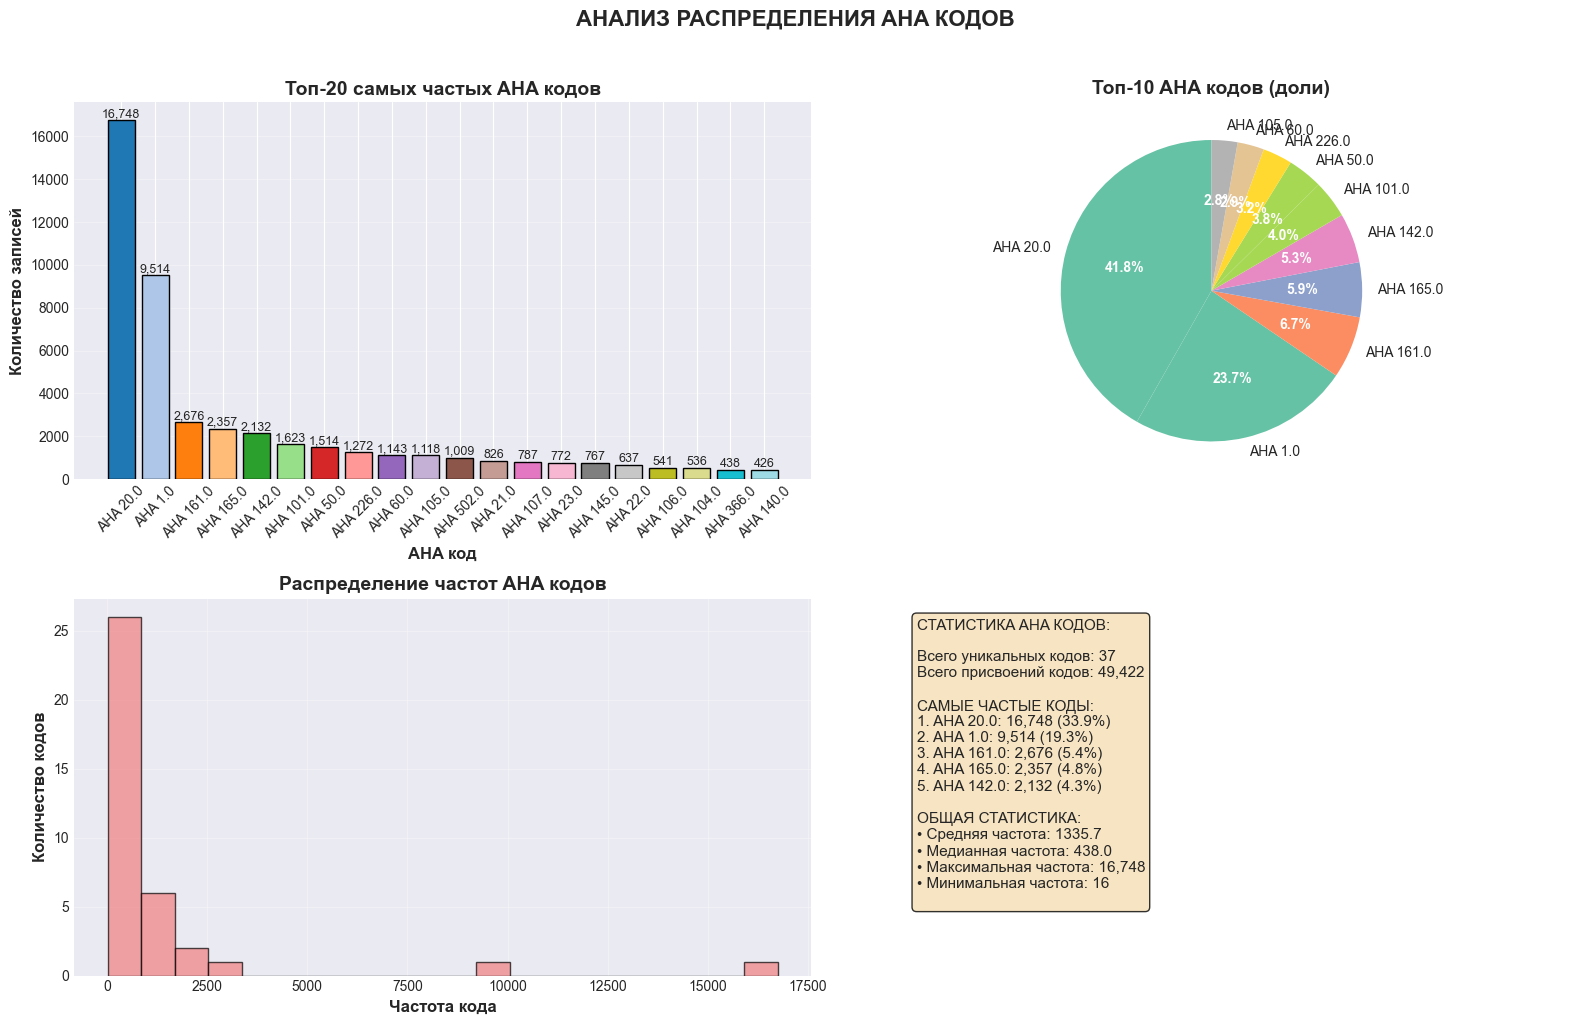

  5. Сравнительный анализ записей с AHA кодами и без них...

СРАВНИТЕЛЬНЫЙ АНАЛИЗ: ЗАПИСИ С AHA КОДАМИ vs БЕЗ AHA КОДОВ

РАСПРЕДЕЛЕНИЕ:
  • Всего записей: 21,799
  • С AHA кодами: 21,420 (98.3%)
  • Без AHA кодов: 379 (1.7%)

СРАВНЕНИЕ ПО ВОЗРАСТУ:
  • С AHA кодами:
    - Средний: 59.5 лет
    - Медиана: 61.0 лет
    - Стандартное отклонение: 16.7
  • Без AHA кодов:
    - Средний: 65.9 лет
    - Медиана: 68.0 лет
    - Стандартное отклонение: 14.1

СРАВНЕНИЕ ПО ПОЛУ:
  • С AHA кодами:
    - Женщины: 11,147 (52.0%)
    - Мужчины: 10,273 (48.0%)
  • Без AHA кодов:
    - Женщины: 207 (54.6%)
    - Мужчины: 172 (45.4%)


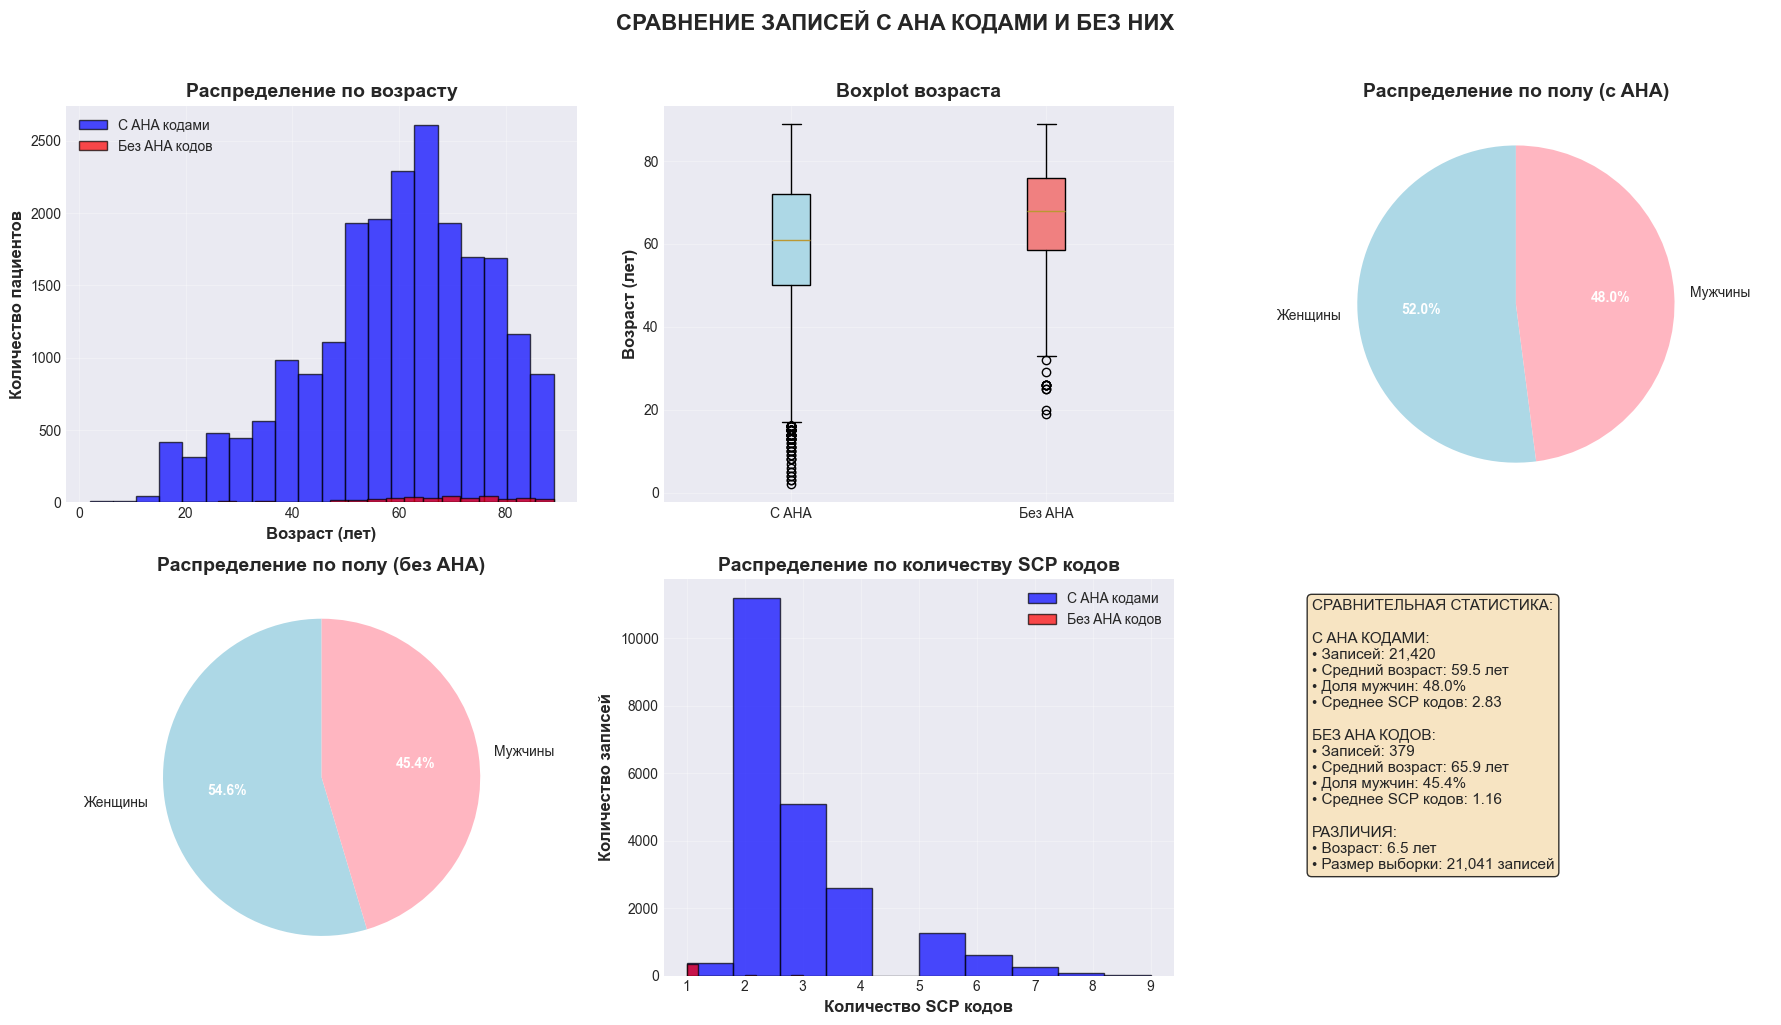


💾 СОХРАНЕНИЕ РЕЗУЛЬТАТОВ В: d:\deep_ecg_2026\analysis_results\ptb_xl
  1. Сохранение сводного отчета...
  2. Сохранение детальной статистики SCP кодов...
  3. Сохранение детальной статистики AHA кодов...
  4. Сохранение сопоставления SCP -> AHA...
  5. Сохранение детальных данных по SCP кодам записей...
  6. Сохранение детальных данных по AHA кодам записей...
  7. Сохранение исправленные данные пациентов...

✅ Все результаты успешно сохранены в: d:\deep_ecg_2026\analysis_results\ptb_xl
   • summary_report.txt - сводный отчет
   • scp_codes_detailed_statistics.csv - детальная статистика SCP кодов
   • aha_codes_detailed_statistics.csv - детальная статистика AHA кодов
   • scp_to_aha_mapping.csv - сопоставление SCP -> AHA
   • records_scp_codes_detailed.csv - детальные данные по SCP кодам записей
   • records_aha_codes_detailed.csv - детальные данные по AHA кодам записей
   • patients_corrected_data.csv - исправленные данные пациентов

АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!

📋 ИТОГОВАЯ СВОДКА:
  • Вс

In [12]:
main()